# Retrieval of Bottom Temps from ERDDAP Dataset for distribution


In [58]:
import datetime
from erddapy import ERDDAP
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

#using xarray for bathymetry data read
import xarray as xa

In [59]:
#search and boundary parameters

server_url = 'http://akutan.pmel.noaa.gov:8080/erddap/'

deployments = []

constraints = {
    'time>=': '2010-01-01T00:00:00Z',
    'time<=': datetime.datetime.utcnow().strftime('%Y-%m-%dT00:00:00Z'),
    'depth>=': 35,
}

variables = ['latitude, longitude, temperature, time, depth, timeseries_id']


In [60]:
e = ERDDAP(server=server_url)
df_1 = pd.read_csv(e.get_search_url(response='csv', search_for='ckp2a -ADCP -gridded -preliminary'))
e = ERDDAP(server=server_url)
df_2 = pd.read_csv(e.get_search_url(response='csv', search_for='ckip2a -gridded -preliminary'))
df = pd.concat([df_1,df_2])
print(sorted(df['Dataset ID'].values))

['datasets_Mooring_10ckip2a_final', 'datasets_Mooring_11ckip2a_final', 'datasets_Mooring_12ckip2a_final', 'datasets_Mooring_13ckp2a_final', 'datasets_Mooring_14ckp2a_final', 'datasets_Mooring_15ckp2a_final', 'datasets_Mooring_16ckip2a_final', 'datasets_Mooring_16ckp2a_final', 'datasets_Mooring_17ckip2a_final', 'datasets_Mooring_17ckp2a_final', 'datasets_Mooring_18ckip2a_final', 'datasets_Mooring_18ckp2a_final', 'datasets_Mooring_19ckp2a_final']


In [61]:
from requests.exceptions import HTTPError

dfs = {}
for dataset_id in sorted(df['Dataset ID'].values):
    print(dataset_id)
    try:
        d = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        d.dataset_id=dataset_id
        d.variables = variables
        d.constraints = constraints
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))

    try:
        df_m = d.to_pandas(
                    index_col='time (UTC)',
                    parse_dates=True,
                    skiprows=(1,)  # units information can be dropped.
                    )
        df_m.sort_index(inplace=True)
        df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
        
        #-9999 and 1e35 are missing values... but erddap doesn't catch the -9999 yet 
        #and some 1e35 are off a bit
        df_m['depth'][(df_m.depth == -9999)] = np.nan # only in pressure field
        dfs.update({dataset_id:df_m})
    except:
        pass


datasets_Mooring_10ckip2a_final
datasets_Mooring_11ckip2a_final
datasets_Mooring_12ckip2a_final
datasets_Mooring_13ckp2a_final
datasets_Mooring_14ckp2a_final
datasets_Mooring_15ckp2a_final
datasets_Mooring_16ckip2a_final
datasets_Mooring_16ckp2a_final
datasets_Mooring_17ckip2a_final
datasets_Mooring_17ckp2a_final
datasets_Mooring_18ckip2a_final
datasets_Mooring_18ckp2a_final
datasets_Mooring_19ckp2a_final


In [62]:
merged_dataset = pd.DataFrame()
for dataset in dfs:
    dfg = dfs[dataset].dropna().groupby('timeseries_id')
    print(dfs[dataset].dropna().groupby('timeseries_id').groups.keys())
    for name in dfs[dataset].dropna().groupby('timeseries_id').groups.keys():
        if not 'wcp' in name:
            print(name)
            merged_dataset = pd.concat([merged_dataset,pd.DataFrame(dfs[dataset].dropna().groupby('timeseries_id').get_group(name))])

dict_keys(['10ckip2a_an9_0040m'])
10ckip2a_an9_0040m
dict_keys(['11ckip2a_an9_0038m'])
11ckip2a_an9_0038m
dict_keys(['12ckip2a_an9_0041m'])
12ckip2a_an9_0041m
dict_keys(['13ckp2a_sc_0039m', '13ckp2a_wcp_scal'])
13ckp2a_sc_0039m
dict_keys(['14ckp2a_sc_0039m'])
14ckp2a_sc_0039m
dict_keys(['15ckp2a_sc_0038m', '15ckp2a_wcp_scal'])
15ckp2a_sc_0038m
dict_keys(['16ckip2a_an9_0039m'])
16ckip2a_an9_0039m
dict_keys(['16ckp2a_mt3167_0041m', '16ckp2a_mt4022_0041m', '16ckp2a_sc_0040m'])
16ckp2a_mt3167_0041m
16ckp2a_mt4022_0041m
16ckp2a_sc_0040m
dict_keys(['17ckip2a_an9_0037m'])
17ckip2a_an9_0037m
dict_keys(['17ckp2a_sc_0039m'])
17ckp2a_sc_0039m
dict_keys(['18ckip2a_an9_0039m', '18ckip2a_s37_0040m'])
18ckip2a_an9_0039m
18ckip2a_s37_0040m
dict_keys(['18ckp2a_sc_0039m', '18ckp2a_wcp_scal'])
18ckp2a_sc_0039m
dict_keys(['19ckp2a_sc_0039m'])
19ckp2a_sc_0039m


<AxesSubplot:xlabel='time (UTC)'>

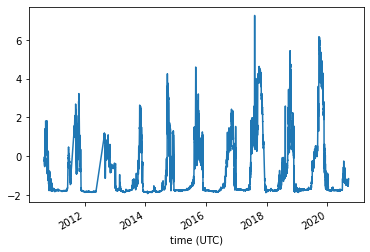

In [63]:
merged_dataset.temperature.plot()

In [55]:
merged_dataset.to_csv('10ckp2a_BottomTemp.csv')
merged_dataset.resample('1H').mean().to_csv('10ckp2a_BottomTemp_hourly.csv')
tmp = merged_dataset.resample('1H').mean()
tmp[tmp.index.hour == 12].drop(['depth','latitude','longitude'],axis=1).to_csv('10ckp2a_BottomTemp_12utc.csv')